[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLE_BayesianInference.ipynb)

# Maximum Likelihood

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Set random seed for reproducibility
# This ensures the same random numbers are generated each time
np.random.seed(1234)

Lets assume that a thumbtack has a probability $0 < \theta^* < 1$ of _heads_ .
We use a **Bernoulli** distribution [$\mathrm{Bernoulli}(x | \theta) = \theta^{x} (1-\theta)^{1-x}$] to model this

In [2]:
# Define Bernoulli probability mass function (PMF)
# Bernoulli(x | theta) = theta^x * (1-theta)^(1-x)
# For x=1 (heads): returns theta
# For x=0 (tails): returns (1-theta)
# This lambda function supports broadcasting - can take scalar or array inputs
Bernoulli = lambda theta,x: theta**x * (1-theta)**(1-x)

# True probability of heads
theta_star = .4

# Example: probability of observing heads (x=1) with theta=0.4
Bernoulli(theta_star, 1)

0.4

The **likelihood** of $\theta^* = \theta$ is 
$$L(\theta) = \prod_{n=1}^{10} \mathrm{Bernoulli}(\theta, x^{(n)})$$
Note that this is a function of $\theta$, it is not a probability distribution, so it doesn't sum to 1.

observation [1 0 0 0 0 1 1 0 0 0]


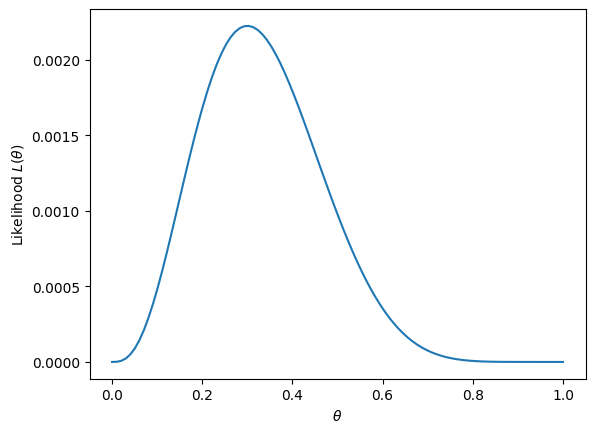

In [3]:
n = 10                                                              # Number of coin flips to simulate

# Generate n Bernoulli random samples
# np.random.rand(n) creates n uniform random numbers in [0,1)
# Comparison with theta_star creates boolean array: True with probability theta_star
xn = np.random.rand(n) < theta_star                                 

# Convert boolean to integers: False->0 (tails), True->1 (heads)
xn = xn.astype(int)                                                 
print("observation {}".format(xn))

# Define likelihood function L(theta)
# IMPORTANT BROADCASTING EXPLANATION:
# - theta can be scalar or array of shape (M, 1)
# - xn has shape (n,), but we use xn[None,:] to make it (1, n)
# - xn[None,:] adds a new axis at position 0: (n,) -> (1, n)
# - If theta is (M, 1) and xn[None,:] is (1, n), broadcasting gives (M, n)
# - Bernoulli(theta, xn[None,:]) computes probability for each (theta_i, x_j) pair
# - np.prod(..., axis=-1) multiplies along last axis (the data axis)
# - Result: scalar if theta is scalar, shape (M,) if theta is (M, 1)
L = lambda theta: np.prod(Bernoulli(theta, xn[None,:]), axis=-1)

# Generate 100 evenly spaced theta values from 0 to 1
theta_vals = np.linspace(0,1,100)[:, None]                         
# Note: [:, None] adds second dimension: (100,) -> (100, 1)
# This makes theta_vals broadcastable with xn[None,:] in the likelihood function

# Plot likelihood as a function of theta
plt.plot(theta_vals, L(theta_vals), '-')
plt.xlabel(r"$\theta$")
plt.ylabel(r"Likelihood $L(\theta)$")
# Note: likelihood is NOT a probability distribution (doesn't integrate to 1)
# It measures how well different theta values explain the observed data
plt.show()

**maximum likelihood** method for learning a probabilistic model picks $\theta$ that maximizes $L(\theta)$ for a given set of observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$. 
For _Bernoulli_ dist. max. likelihood estimate is the $\widehat{\theta} = \frac{1}{N} \sum_n x^{(n)}$, corresponding to the peak of the likelihood plot. The value of the likelihood shrinks exponentially as we increase the number of observations $N$ -- try `N=100`. 
A more numerically stable value with the same _maximum_ is the **log-likelihood** $\ell(\theta) = \log(L(\theta))$. It is also customary to minimize the _negative log-likelihood_ (NLL).
Let's plot NLL for different $N$ -- as we increase our data-points the ML estimate often gets better.

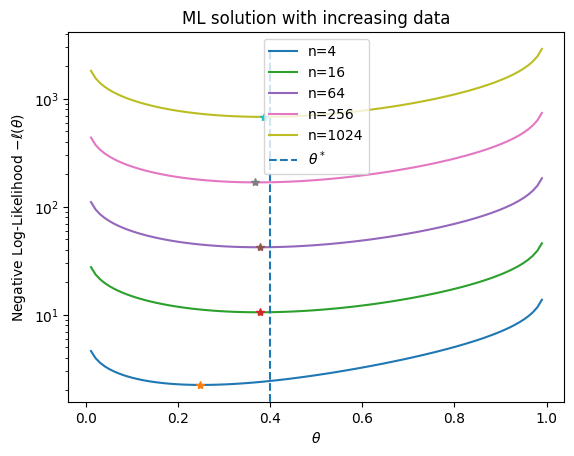

In [4]:
# Generate many samples to test with different dataset sizes
# 2^12 = 4096 samples
xn_max = np.random.rand(2**12) < theta_star

# Test with increasing number of samples
for r in range(1,6):
    n = 4**r              # Number of samples: 4, 16, 64, 256, 1024
    
    # Slice first n samples from the pre-generated data
    # This ensures all experiments use the same underlying random sequence
    xn = xn_max[:n]       
    
    # Define log-likelihood function
    # BROADCASTING EXPLANATION:
    # - Similar to likelihood L, but using log for numerical stability
    # - np.log(Bernoulli(theta, xn[None,:])) has shape (M, n) if theta is (M, 1)
    # - np.sum(..., axis=-1) sums over the data dimension
    # - Result: shape (M,) giving log-likelihood for each theta value
    ll = lambda theta: np.sum(np.log(Bernoulli(theta, xn[None,:])), axis=-1)
    
    # Create theta values, avoiding 0 and 1 to prevent log(0)
    # Shape: (100, 1) for broadcasting
    theta_vals = np.linspace(.01,.99,100)[:, None]
    
    # Compute negative log-likelihood (NLL)
    # We negate because we want to minimize, not maximize
    ll_vals = -ll(theta_vals)
    
    # Plot NLL curve for this sample size
    plt.plot(theta_vals, ll_vals, label="n="+str(n))
    
    # Find theta that minimizes NLL (= maximizes likelihood)
    # np.argmin returns the index of the minimum value
    max_ind = np.argmin(ll_vals)                            
    
    # Mark the optimal theta with a star
    plt.plot(theta_vals[max_ind], ll_vals[max_ind], '*')

# Plot vertical line at true theta* value for reference
plt.plot([theta_star,theta_star], [0,ll_vals.max()], '--', label=r"$\theta^*$")

plt.xlabel(r"$\theta$")
plt.ylabel(r"Negative Log-Likelihood $-\ell(\theta)$")

# Use log scale for y-axis to see all curves clearly
# As n increases, NLL values grow (more data = more terms in sum)
plt.yscale("log")

plt.title("ML solution with increasing data")
plt.legend()
plt.show()

ML estimate does not reflect our uncertainty. We could estimate $\widehat{\theta} = .2$ by observing 2 heads in 10 trials or 200 heads in 1000 trials. A Bayesian approach solves this problem.

# Bayesian Inference

In the Bayesian setting, probabilities reflect our uncertainty. We start by having a **prior** belief $p(\theta)$ about the right model of the world.
We then make observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, with likelihood $p(\mathcal{D} \mid \theta)$, and update our belief to a **poseterior belief** $p(\theta \mid \mathcal{D})$. **Bayes rule** lets us calculate this posterior probability:
$$ p(\theta \mid \mathcal{D}) = \frac{p(\theta) p(\mathcal{D} \mid \theta)}{p(\mathcal{D})} $$
The denominator $p(\mathcal{D}) = \int_\theta p(\theta) p(\mathcal{D} \mid \theta) \mathrm{d}\theta$, called _evidence_,  makes sure that the posterior sums to one.

### Conjugate Priors
When using Bayes rule, ideally we want the prior and posterior to belong to the same family of distributions. For example, this way we can update our belief as we observe more data using successive applications of Bayes rule. Certain pairing of the likelihood family of distribution $p(x^{(n)} \mid \theta)$ and the prior enable this behaviour. When this is true we say 
that the prior is **conjugate** to the likelihood. 

#### Beta-Bernoulli conjugate pair
Looking close at Bernoulli $\mathrm{Bernoulli}(x | \theta) = \theta^{x} (1-\theta)^{1-x}$, its conjugate prior $p(\theta)$ should have $\theta$ and $1-\theta$ as the basis in an exponentiation and the parameters of the prior should appear in the exponent. Beta distribution has this exact form
$$\mathrm{Beta}(\theta \mid \alpha, \beta) \propto \theta^{\alpha-1} (1-\theta)^{\beta - 1}$$
Here, $\propto$ sign means that we have dropped the normalization $B(\alpha,\beta)$, called the Beta function (`beta(a,b)` below). Lets plot Beta distribution for different values of $\alpha, \beta > 0$:

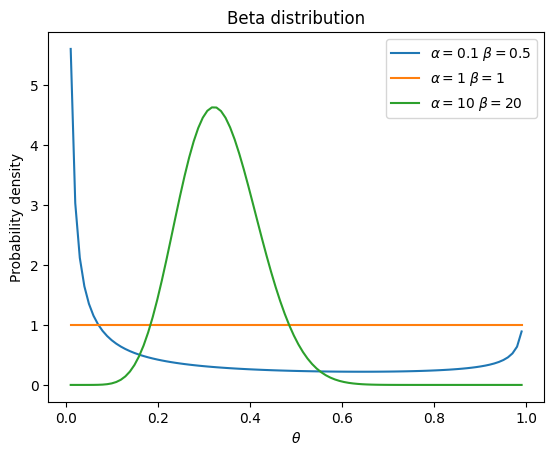

In [5]:
from scipy.special import beta                                      # Import beta function B(a,b) for normalization

# Define Beta probability density function (PDF)
# Beta(theta | a, b) = theta^(a-1) * (1-theta)^(b-1) / B(a,b)
# where B(a,b) is the beta function that normalizes the distribution
# Parameters a, b > 0 control the shape:
#   - a=b=1: uniform distribution
#   - a<1, b<1: U-shaped
#   - a>1, b>1: bell-shaped, concentrated in middle
#   - a>b: skewed right (favors higher theta)
#   - a<b: skewed left (favors lower theta)
Beta = lambda theta,a,b: ((theta**(a-1))*((1-theta)**(b-1)))/beta(a,b)

# Visualize Beta distribution for different parameter values
for a,b in [(.1,.5), (1,1), (10,20)]:
    # Create 100 theta values, avoiding exactly 0 and 1
    # (Beta PDF is undefined at boundaries for some parameter values)
    theta_vals = np.linspace(.01,.99,100)
    
    # Compute PDF values for this (a,b) combination
    p_vals = Beta(theta_vals, a, b)
    
    # Plot the distribution
    plt.plot(theta_vals, p_vals, label=r"$\alpha=$"+str(a)+r" $\beta=$"+str(b))

plt.xlabel(r"$\theta$")
plt.ylabel(r"Probability density")
plt.title("Beta distribution")
plt.legend()
plt.show()

Lets see what the posterior looks like after observing a single instance $x \in \{0,1\}$:
$$\mathrm{Beta}(\theta|\alpha, \beta) \mathrm{Bernoulli}(x| \theta) \propto \theta^{\alpha + x - 1} (1-\theta)^{\beta + (1-x) - 1} \propto \mathrm{Beta}(\theta \mid \alpha+x, \beta+(1-x))$$

Therefore, observing a head will increase $\alpha$ by one, and observing a tail will increase $\beta$ in the posterior by the same amount. Observing $n_h$ heads and $n = n_h$ tails in a dataset will lead to posterior $\mathrm{Beta}(\theta| \alpha+n_h, \beta+n - n_h)$.

Another distribution with a similar form as Bernoulli that has Beta distribution as a conjugate prior is the Binomial distribution. Note that the probability of observing a specific sequence $x^{(1)}, \ldots, x^{(n)}$, only depends on the total _number of heads ($nh$) and tails ($nt=N-nh$)_ in that sequence. 
**Binomial** distribution gives the probability of all such outcomes: 
$$\mathrm{Binomial}(n, n_h, \theta) = {n \choose n_h} \theta^{n_h} (1-\theta)^{n-n_h}$$

Now, let's go back to the example where we increase the number of observations $N$ and see how this affects our posterior belief about the value of $\theta^*$. We start from a uniform prior over $\theta$ corresponding to $\alpha=\beta=10$.

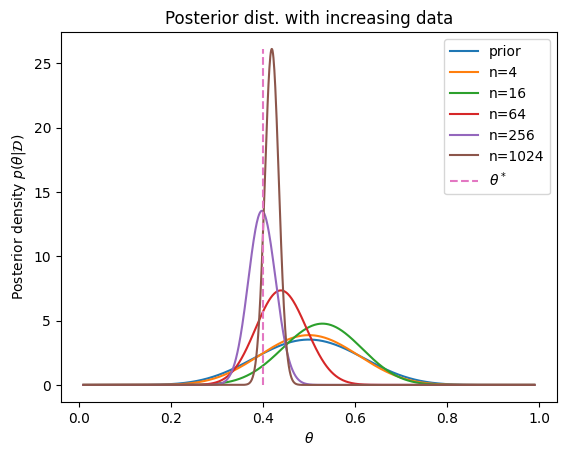

In [6]:
# Generate random samples (same as before)
xn_max = np.random.rand(2**12) < theta_star

# Prior parameters: a0 = b0 = 10 gives a symmetric prior centered at 0.5
# This represents a moderately strong prior belief that theta is around 0.5
a0, b0 = 10, 10

# Create theta values for plotting
# Shape: (1000, 1) to enable broadcasting if needed
theta_vals = np.linspace(.01,.99,1000)[:, None]

# Compute and plot the prior distribution
# This is our initial belief before seeing any data
posterior = Beta(theta_vals, a0, b0)              
plt.plot(theta_vals, posterior , label="prior")

# Update posterior with increasing amounts of data
for r in range(1,6):
    n = 4**r                          # Number of samples: 4, 16, 64, 256, 1024
    xn = xn_max[:n]                   # Take first n samples
    
    # Count number of heads (1s) in the data
    # np.sum on boolean/integer array counts the True/1 values
    nh = np.sum(xn)                   
    
    # Bayesian update: posterior = Beta(a0 + nh, b0 + (n-nh))
    # - Each head (x=1) increments the first parameter
    # - Each tail (x=0) increments the second parameter
    # - Posterior has same functional form as prior (conjugacy)
    posterior = Beta(theta_vals, a0+nh, b0+n-nh)
    
    # Plot the posterior for this amount of data
    plt.plot(theta_vals, posterior , label="n="+str(n)) 

# Plot vertical line at true theta* for reference
# posterior.max() ensures the line spans the full height of the plot
plt.plot([theta_star,theta_star], [0,posterior.max()], '--', label=r"$\theta^*$")

plt.xlabel(r"$\theta$")
plt.ylabel(r"Posterior density $p(\theta|\mathcal{D})$")
plt.title("Posterior dist. with increasing data")
plt.legend()
plt.show()

# Note how the posterior:
# 1. Starts at the prior (wide, centered at 0.5)
# 2. Becomes more peaked as n increases (less uncertainty)
# 3. Centers around theta* (data overcomes prior)

Note that the posterior becomes more peaked around $\theta^*$, while also reflecting our uncertainty about the model.
### Posterior predictive
The purpose of learning a model is to make predictions. When we have a distribution over model parameters, we can look at the expected outcome -- i.e., using weighted average of predictions. 
When using posterior distribution $p(\theta| \mathcal{D})$ for this purpose, the _expected outcome_ is called the _posterior predictive_:
$$p(x | \mathcal{D}) = \int_\theta p(\theta | \mathcal{D}) p(x | \theta) \mathrm{d} \theta$$

For Beta-Bernoulli this is the same as the posterior mean 
$$p(x | \mathcal{D}) = \int_\theta \mathrm{Beta}(\theta | \alpha+ n_h, \beta+n-n_h)  \theta \mathrm{d} \theta = \frac{B(\alpha, \beta)}{B(\alpha+n_h,\beta)} = \frac{\alpha + n_h}{\alpha+\beta+n}.$$
In practical terms, the posterior predictive distribution for the probability of seeing a head smoothens the maximum-likelihood based estimate by adding pseudo-counts $\alpha_0, \beta_0$. In the context of Bernoulli (Binomial) and Multinomial distributions this smoothed prediction is also known as **Laplace smoothing**.

### Maximum a Posteriori (MAP) inference

In many applications calculating the posterior distribution is not easy.
A cheap alternative is to calculate the mode (maximum) of the posterior distribution:
    $$ \max_\theta p(\theta| x) = \max_\theta p(\theta) p(x | \theta)$$

This expression has the same maximum as the logarithm of the posterior: $\log p(\theta| x) = \log  p(\theta) + \ell(\theta)$, where the second term is the log-likelihood.
Therefore MAP inference simply adds a _regularizer_ term to the log-likelihood that takes into account our prior belief about the model. 